In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import gc
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from numpy import sort
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb

plt.style.use('ggplot')

In [2]:
os.getcwd()

'D:\\PyCharm\\mvts_fss_ay'

In [70]:
len(os.listdir(os.path.join(os.getcwd(),'data\partition1')))

2

In [9]:
path = os.path.join(os.getcwd(),'data\partition1')
path

'D:\\PyCharm\\mvts_fss_ay\\data\\partition1'

In [11]:
files = pd.read_csv(os.path.join(path,'FL','M1.0@265_Primary_ar115_s2010-08-06T06_36_00_e2010-08-06T18_24_00.csv'),sep="\t")
files.head(5)

,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,...,BFLARE_LABEL_LOC,CFLARE_LOC,CFLARE_LABEL_LOC,MFLARE_LOC,MFLARE_LABEL_LOC,XFLARE_LOC,XFLARE_LABEL_LOC,XR_MAX,XR_QUAL,IS_TMFI
0,2010-08-06 06:36:00,980.993502,1.551270e+10,2.240189e+23,1.936230e+13,151.979938,3.821906e+12,1.766054e+22,-7.202945e+24,6004.885593,...,None,0.0,None,0.0,None,0.0,None,2.745600e-07,12,True
1,2010-08-06 06:48:00,987.271725,1.555048e+10,2.252867e+23,1.971309e+13,150.347978,3.570546e+12,1.781535e+22,-7.201674e+24,5907.434832,...,None,0.0,None,0.0,None,0.0,None,2.611100e-07,12,True
2,2010-08-06 07:00:00,985.015683,1.550109e+10,2.238914e+23,1.962561e+13,153.069350,4.284650e+12,1.775269e+22,-7.188077e+24,5909.535936,...,None,0.0,None,0.0,None,0.0,None,2.534100e-07,12,True
3,2010-08-06 07:12:00,993.944093,1.554684e+10,2.233768e+23,1.978907e+13,154.994888,3.122913e+12,1.799766e+22,-7.273269e+24,5779.465192,...,None,0.0,None,0.0,None,0.0,None,2.259200e-07,12,True
4,2010-08-06 07:24:00,994.364606,1.564230e+10,2.242762e+23,1.986232e+13,153.108332,3.790034e+12,1.826607e+22,-7.339826e+24,5692.225659,...,None,0.0,None,0.0,None,0.0,None,2.111100e-07,12,True


In [91]:
class Sample:
    def __init__(self,flare_type,file_name):
        self.flare_type = flare_type
        self.file_name = file_name
        path = os.path.join(os.getcwd(),'data\partition1')
        
    def get_flare_class(self):
        return self.file_name[0]
    
    def __get_start_end_index(self):
        start_index = self.file_name.find("_s")
        end_index = self.file_name.find("_e")
        return start_index,end_index
    
    def get_start_time(self):
        s,e = self.__get_start_end_index()
        return self.file_name[s: e]
    
    def get_end_time(self):
        _,e = self.__get_start_end_index()
        return self.file_name[e:]
    
    def get_number_of_files(self):
        return len(os.listdir(os.path.join(path,self.flare_type)))
    
    def get_data(self):
        try:
            return pd.read_csv(os.path.join(path,self.flare_type,self.file_name),sep="\t")
        
        except FileNotFoundError:
            print("File not found")

In [92]:
Sample("FL","M1.0@265_Primary_ar115_s2010-08-06T06_36_00_e2010-08-06T18_24_00.csv").get_data().head()

,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,...,BFLARE_LABEL_LOC,CFLARE_LOC,CFLARE_LABEL_LOC,MFLARE_LOC,MFLARE_LABEL_LOC,XFLARE_LOC,XFLARE_LABEL_LOC,XR_MAX,XR_QUAL,IS_TMFI
0,2010-08-06 06:36:00,980.993502,1.551270e+10,2.240189e+23,1.936230e+13,151.979938,3.821906e+12,1.766054e+22,-7.202945e+24,6004.885593,...,None,0.0,None,0.0,None,0.0,None,2.745600e-07,12,True
1,2010-08-06 06:48:00,987.271725,1.555048e+10,2.252867e+23,1.971309e+13,150.347978,3.570546e+12,1.781535e+22,-7.201674e+24,5907.434832,...,None,0.0,None,0.0,None,0.0,None,2.611100e-07,12,True
2,2010-08-06 07:00:00,985.015683,1.550109e+10,2.238914e+23,1.962561e+13,153.069350,4.284650e+12,1.775269e+22,-7.188077e+24,5909.535936,...,None,0.0,None,0.0,None,0.0,None,2.534100e-07,12,True
3,2010-08-06 07:12:00,993.944093,1.554684e+10,2.233768e+23,1.978907e+13,154.994888,3.122913e+12,1.799766e+22,-7.273269e+24,5779.465192,...,None,0.0,None,0.0,None,0.0,None,2.259200e-07,12,True
4,2010-08-06 07:24:00,994.364606,1.564230e+10,2.242762e+23,1.986232e+13,153.108332,3.790034e+12,1.826607e+22,-7.339826e+24,5692.225659,...,None,0.0,None,0.0,None,0.0,None,2.111100e-07,12,True


In [34]:
variates_to_calc_on = [ 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT','EPSZ','MEANSHR','SHRGT45','MEANGAM','MEANGBT',
                           'MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

In [96]:
flare_sample = sample("FL","M1.0@265_Primary_ar115_s2010-08-06T06_36_00_e2010-08-06T18_24_00.csv").get_data()
flare_sample.sample(5)

,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,TOTFZ,MEANPOT,...,BFLARE_LABEL_LOC,CFLARE_LOC,CFLARE_LABEL_LOC,MFLARE_LOC,MFLARE_LABEL_LOC,XFLARE_LOC,XFLARE_LABEL_LOC,XR_MAX,XR_QUAL,IS_TMFI
36,2010-08-06 13:48:00,938.293427,1.427570e+10,2.176779e+23,1.779977e+13,135.361327,4.486338e+12,1.554907e+22,-6.048972e+24,6898.798576,...,None,0.0,None,0.0,None,0.0,None,1.375600e-07,12,True
39,2010-08-06 14:24:00,936.951265,1.418837e+10,2.181070e+23,1.773775e+13,146.342952,4.338235e+12,1.535476e+22,-5.895875e+24,6997.515355,...,None,0.0,None,0.0,None,0.0,None,1.307200e-07,12,True
28,2010-08-06 12:12:00,979.301230,1.455523e+10,2.178199e+23,1.867788e+13,133.960830,4.652058e+12,1.608190e+22,-6.347586e+24,6728.013416,...,None,0.0,None,0.0,None,0.0,None,1.474000e-07,12,True
33,2010-08-06 13:12:00,958.669838,1.437341e+10,2.178074e+23,1.834409e+13,135.858300,4.267536e+12,1.576808e+22,-6.123328e+24,6790.298621,...,None,0.0,None,0.0,None,0.0,None,1.380700e-07,12,True
2,2010-08-06 07:00:00,985.015683,1.550109e+10,2.238914e+23,1.962561e+13,153.069350,4.284650e+12,1.775269e+22,-7.188077e+24,5909.535936,...,None,0.0,None,0.0,None,0.0,None,2.534100e-07,12,True


In [97]:
cols = np.array(flare_sample.columns[1:25])
cols

array(['TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP',
       'USFLUX', 'TOTFZ', 'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45',
       'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZH', 'TOTFY',
       'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'R_VALUE'],
      dtype=object)

In [103]:
features = []
for col in cols:
    features.append(f'{col}_MIN')
    features.append(f'{col}_MEAN')
    features.append(f'{col}_MEDIAN')
    features.append(f'{col}_MAX')
    features.append(f'{col}_STDDEV')
    
features

['TOTUSJH_MEAN',
 'TOTUSJH_STDDEV',
 'TOTBSQ_MEAN',
 'TOTBSQ_STDDEV',
 'TOTPOT_MEAN',
 'TOTPOT_STDDEV',
 'TOTUSJZ_MEAN',
 'TOTUSJZ_STDDEV',
 'ABSNJZH_MEAN',
 'ABSNJZH_STDDEV',
 'SAVNCPP_MEAN',
 'SAVNCPP_STDDEV',
 'USFLUX_MEAN',
 'USFLUX_STDDEV',
 'TOTFZ_MEAN',
 'TOTFZ_STDDEV',
 'MEANPOT_MEAN',
 'MEANPOT_STDDEV',
 'EPSZ_MEAN',
 'EPSZ_STDDEV',
 'MEANSHR_MEAN',
 'MEANSHR_STDDEV',
 'SHRGT45_MEAN',
 'SHRGT45_STDDEV',
 'MEANGAM_MEAN',
 'MEANGAM_STDDEV',
 'MEANGBT_MEAN',
 'MEANGBT_STDDEV',
 'MEANGBZ_MEAN',
 'MEANGBZ_STDDEV',
 'MEANGBH_MEAN',
 'MEANGBH_STDDEV',
 'MEANJZH_MEAN',
 'MEANJZH_STDDEV',
 'TOTFY_MEAN',
 'TOTFY_STDDEV',
 'MEANJZD_MEAN',
 'MEANJZD_STDDEV',
 'MEANALP_MEAN',
 'MEANALP_STDDEV',
 'TOTFX_MEAN',
 'TOTFX_STDDEV',
 'EPSY_MEAN',
 'EPSY_STDDEV',
 'EPSX_MEAN',
 'EPSX_STDDEV',
 'R_VALUE_MEAN',
 'R_VALUE_STDDEV']

In [140]:
def countList(lst1, lst2): 
    return np.array([[i, j] for i, j in zip(lst1, lst2)]).ravel() 

def get_features(data):
    features = []
    for col in cols:
        features.append(f'{col}_MIN')
        features.append(f'{col}_MEAN')
        features.append(f'{col}_MEDIAN')
        features.append(f'{col}_MAX')
        features.append(f'{col}_STDDEV')
        
    return features

def calculate_descriptive_features(data):
    variates_to_calc_on = list(data.columns[1:25])
    
    features_to_return = get_features(data)
    features = pd.DataFrame(columns = features_to_return)
    mins = [np.min(data.loc[:, col]) for col in variates_to_calc_on]
    means = [np.mean(data.loc[:, col]) for col in variates_to_calc_on]
    medians = [np.median(data.loc[:, col]) for col in variates_to_calc_on]
    maxs = [np.max(data.loc[:, col]) for col in variates_to_calc_on]
    std = [np.std(data.loc[:, col]) for col in variates_to_calc_on]
    measures = (mins,means,medians,maxs,std)
    features.loc[len(features)] = np.concatenate(measures)
    
    return features

In [138]:
data = flare_sample
variates_to_calc_on = list(flare_sample.columns[1:25])
features_to_return = get_features(flare_sample)
features = pd.DataFrame(columns = features_to_return)
mins = [np.min(data.loc[:, col]) for col in variates_to_calc_on]
means = [np.mean(data.loc[:, col]) for col in variates_to_calc_on]
medians = [np.median(data.loc[:, col]) for col in variates_to_calc_on]
maxs = [np.max(data.loc[:, col]) for col in variates_to_calc_on]
std = [np.std(data.loc[:, col]) for col in variates_to_calc_on]
measures = (mins,means,medians,maxs,std)
features.loc[len(features)] = np.concatenate(measures)

In [141]:
calculate_descriptive_features(flare_sample)

,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,TOTBSQ_STDDEV,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,915.737843,1.405262e+10,2.159497e+23,1.735059e+13,116.106603,1.617732e+12,1.498661e+22,-7.545494e+24,5491.910988,-0.354495,...,2.057317,1.231493,0.000576,5.630232e+22,0.083763,0.00107,1.536649e+23,0.003628,0.004569,0.072957


In [135]:
features = np

,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,TOTBSQ_STDDEV,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV


In [130]:
calculate_descriptive_features(flare_sample)

ValueError: cannot set a row with mismatched columns

In [163]:
def process_flare_data(partition_location,final_data_fl):
    
    path_FL = os.path.join(partition_location, "FL")
    column_index = final_data_fl.columns.get_loc('FLARE_TYPE')
    i=0
    print("Processing Flare files")
 
    for file in tqdm(os.listdir(path_FL)):
        
        sample = Sample("FL",file)
        data = sample.get_data()
        features = calculate_descriptive_features(data) 
        final_data_fl = final_data_fl.append(features)
        final_data_fl.iat[i,column_index] = sample.get_flare_class()
        i+=1
 
  
    return final_data_fl.reset_index(drop=True)

def process_non_flare_data(partition_location,final_data_nf):
    column_index = final_data_nf.columns.get_loc('FLARE_TYPE')
    i=0
    path_NF = os.path.join(partition_location, "NF")
    print('Processing Non-Flare files')
    
    for file in tqdm(os.listdir(path_NF)):
        
        sample = Sample("NF",file)
        data = sample.get_data()
        features = calculate_descriptive_features(data) 
        final_data_nf = final_data_nf.append(features)
        final_data_nf.iat[i,column_index] = sample.get_flare_class()
        i+=1

    return final_data_nf.reset_index(drop=True)
        
def process_partition(partition_location:str):
    abt_header = ['FLARE_TYPE'] + get_features(flare_sample)
    
    
    final_data_fl = pd.DataFrame(columns =abt_header)
    final_data_nf = pd.DataFrame(columns =abt_header)
    
    flare_data = process_flare_data(partition_location,final_data_fl)
    non_flare_data = process_non_flare_data(partition_location,final_data_nf)
    

    table = pd.concat([flare_data, non_flare_data], axis=0, ignore_index=True)
    
    # Saving dataframe as csv with name extracted from abt_name
#     table.to_csv(path,index=False,header=True)
    
    return table
   


In [165]:
final_data = process_partition(path)

Processing Flare files


  0%|          | 0/1254 [00:00<?, ?it/s]

Processing Non-Flare files


  0%|          | 0/72238 [00:00<?, ?it/s]

In [172]:
extracted_features = final_data
save_path = os.path.join(os.getcwd(),"data","extracted_features.csv")
extracted_features.to_csv(save_path,index = False, header=True)

'D:\\PyCharm\\mvts_fss_ay\\data\\extracted_features.csv'

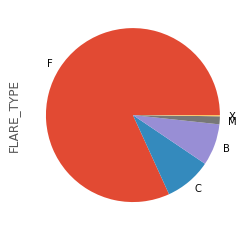

In [179]:
final_data['FLARE_TYPE'].value_counts().plot(kind='pie');

In [183]:
final_data.sample(10)

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
45368,F,34.079809,2.698088e+08,2.018976e+21,7.776040e+11,4.086034,1.167839e+11,5.073047e+20,-2.966929e+23,1496.320835,...,4.394161,2.922789,0.001722,8.407980e+21,0.298468,0.006289,8.553319e+21,0.015156,0.024376,0.000000
57041,F,102.831232,9.611403e+08,5.848392e+21,2.195499e+12,1.937601,1.143914e+11,1.838590e+21,-1.086924e+24,1261.335076,...,6.883269,2.292094,0.000981,1.456172e+22,0.149304,0.003499,2.044294e+22,0.008094,0.007728,0.000000
23730,F,11.540024,7.016882e+07,5.752491e+20,2.712361e+11,0.017470,1.578130e+10,1.511889e+20,-8.585217e+22,1420.781477,...,8.068715,3.776806,0.005279,7.548237e+21,1.256528,0.025012,4.275696e+21,0.035388,0.029215,0.946710
12564,C,1396.554429,1.257057e+10,1.856731e+23,2.730282e+13,2.165902,4.326118e+11,1.318191e+22,-5.956961e+24,4979.266476,...,5.395058,2.427689,0.005952,1.367984e+23,0.096432,0.015017,9.111492e+22,0.002664,0.014686,0.073863
28772,F,21.099108,1.308044e+08,9.877569e+20,4.622439e+11,1.365173,9.165820e+09,2.588296e+20,-1.488343e+23,1351.034652,...,6.428783,2.208360,0.004659,5.929501e+21,0.550600,0.019122,3.654420e+21,0.011674,0.020467,0.000000
18515,F,105.782189,9.116910e+08,5.817750e+21,2.471300e+12,16.761278,9.165934e+11,1.867326e+21,-1.051138e+24,1218.456606,...,6.306861,2.242870,0.001518,2.085458e+22,0.168151,0.005084,2.392489e+22,0.017028,0.006300,0.000000
7824,C,1939.496731,1.526488e+10,1.566251e+23,4.141684e+13,6.061527,1.004480e+13,2.304118e+22,-9.802146e+24,2710.615737,...,2.995954,1.736522,0.000982,7.755608e+22,0.091230,0.003398,4.978219e+23,0.002350,0.023671,0.134121
30442,F,57.261943,4.165243e+08,2.414368e+21,1.294517e+12,0.212968,2.610161e+10,8.229369e+20,-4.288034e+23,1148.124649,...,6.465814,3.472455,0.004662,1.291259e+22,0.789717,0.021569,1.529630e+22,0.012439,0.025411,0.209595
11893,C,1911.467777,1.987069e+10,3.618342e+23,3.704614e+13,199.751716,7.731226e+12,1.856319e+22,-4.667608e+24,8504.077309,...,2.990875,1.468799,0.001171,1.010188e+23,0.042562,0.002788,2.045598e+23,0.003186,0.009813,0.098387
6897,B,1264.294062,9.349392e+09,8.014119e+22,2.804218e+13,103.524117,4.716389e+12,1.526183e+22,-7.470993e+24,1922.196203,...,4.349087,2.800572,0.001747,1.404164e+23,0.100096,0.005092,2.583355e+23,0.006063,0.019507,0.794844


In [180]:
final_data['FLARE_TYPE'].value_counts()

F    60130
C     6416
B     5692
M     1089
X      165
Name: FLARE_TYPE, dtype: int64

In [184]:
gc.collect()

11179

In [185]:
del flare_sample

In [186]:
final_data

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.638313e+23,1213.622123,...,4.798655,1.371292,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.015569,0.012921,0.000000
73488,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.632911e+23,1233.768697,...,4.203839,1.357030,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.015419,0.011599,0.000000
73489,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.509804e+23,1233.768697,...,4.245523,1.352633,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.014589,0.011630,0.000000
73490,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.011235,1.833150e+09,3.886825e+20,-2.509804e+23,1210.220238,...,5.210287,1.851682,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,0.013472,0.011363,0.000000


## Summary of each column

In [236]:
def column_stat(feature_name, data):
    summary_feature_names = ['Feature Name', 'Cardinality', 'Non-null Count', 'Null Count', 'Min', '25th', 'Mean', 
                             '50th', '75th', 'Max', 'Outlier Count Low', 'Outlier Count High']
    

    feature_name = feature_name
    descriptive_stats = data[feature_name].describe()
    cardinality = data[feature_name].nunique()
    non_null_values = descriptive_stats['count']
    null_count = data.shape[0] - non_null_values
    min_value = descriptive_stats['min']
    percentile_25 = descriptive_stats['25%']          
    mean = descriptive_stats['mean']   
    percentile_50 = descriptive_stats['50%']   
    percentile_75 = descriptive_stats['75%']   
    max_value = descriptive_stats['max']   
    std = descriptive_stats['std']   
    iqr = percentile_75 - percentile_25
    lower_thershold = percentile_25 - (1.5 * iqr)
    upper_threshold = percentile_75 + (1.5* iqr)
    lower_outlier_count = data[data[feature_name] < lower_thershold].shape[0]
    upper_outlier_count = data[data[feature_name] > upper_threshold].shape[0]
    
    feature_values = [[feature_name,cardinality,non_null_values,null_count,min_value,percentile_25,mean,percentile_50,percentile_75,max_value,lower_outlier_count,upper_outlier_count]]
    features = pd.DataFrame(columns = summary_feature_names, data=feature_values)
   
    return features

In [237]:
def report(data):
    excluded_columns = ['FLARE_TYPE']
    
    summary_feature_names = ['Feature Name', 'Cardinality', 'Non-null Count', 'Null Count', 'Min', '25th', 'Mean', 
                             '50th', '75th', 'Max', 'Outlier Count Low', 'Outlier Count High']
 
    df = pd.DataFrame(columns = summary_feature_names)
    
    for feature in tqdm(data.columns):
        if feature not in excluded_columns:
            row = column_stat(feature, data)
            df = df.append(row)
            
    df = df.reset_index(drop=True)
    df.iloc[:,1:] = df.iloc[:,1:].apply(pd.to_numeric)

    
    return df

In [238]:
summary_table = report(final_datax)

  0%|          | 0/121 [00:00<?, ?it/s]

In [239]:
summary_table

,Feature Name,Cardinality,Non-null Count,Null Count,Min,25th,Mean,50th,75th,Max,Outlier Count Low,Outlier Count High
0,TOTUSJH_MIN,30165,73492.0,0.0,0.000000e+00,2.975612e+01,3.966980e+02,1.100119e+02,4.186145e+02,5.680233e+03,0,9014
1,TOTUSJH_MEAN,36215,73492.0,0.0,0.000000e+00,2.314571e+08,5.461338e+09,9.602488e+08,5.871634e+09,9.670589e+10,0,8990
2,TOTUSJH_MEDIAN,33848,73492.0,0.0,0.000000e+00,1.553084e+21,8.161446e+22,6.720062e+21,6.914324e+22,1.851463e+24,0,10227
3,TOTUSJH_MAX,27957,73492.0,0.0,0.000000e+00,6.596724e+11,8.102719e+12,2.358385e+12,8.662240e+12,1.027754e+14,0,8928
4,TOTUSJH_STDDEV,18624,73492.0,0.0,0.000000e+00,8.582925e-02,3.241827e+01,9.032258e-01,1.547304e+01,2.171286e+03,0,12441
...,...,...,...,...,...,...,...,...,...,...,...,...
115,R_VALUE_MIN,73492,73492.0,0.0,3.108426e-04,2.591137e-03,7.913902e-03,5.539619e-03,1.022840e-02,3.536396e+00,0,3864
116,R_VALUE_MEAN,73492,73492.0,0.0,2.050209e+20,1.196025e+22,6.798644e+22,3.196060e+22,8.325872e+22,1.331271e+24,0,6689
117,R_VALUE_MEDIAN,73492,73492.0,0.0,5.277769e-04,5.329955e-03,1.379390e-02,1.144919e-02,1.941364e-02,1.465891e-01,0,1710
118,R_VALUE_MAX,73492,73492.0,0.0,9.966991e-04,6.854618e-03,1.545925e-02,1.163279e-02,2.058960e-02,1.276262e-01,0,3170


In [240]:
summary_table.dtypes.value_counts()

float64    8
int64      3
object     1
dtype: int64

In [241]:
summary_table.isna().sum()

Feature Name          0
Cardinality           0
Non-null Count        0
Null Count            0
Min                   0
25th                  0
Mean                  0
50th                  0
75th                  0
Max                   0
Outlier Count Low     0
Outlier Count High    0
dtype: int64

In [242]:
final_data.shape, summary_table.shape

((73492, 121), (120, 12))

In [260]:
summary_table.pivot_table(index = 'Feature Name', values = ['Null Count','Cardinality'])\
.sort_values(by='Cardinality')

,Cardinality,Null Count
Feature Name,,
ABSNJZH_MAX,8466,0.0
MEANALP_MIN,14907,0.0
TOTBSQ_MIN,16874,0.0
TOTUSJZ_MAX,17258,0.0
MEANGBH_MEDIAN,17506,0.0
...,...,...
SAVNCPP_MEDIAN,73492,0.0
SAVNCPP_MIN,73492,0.0
SAVNCPP_STDDEV,73492,0.0


In [256]:
rows_less_than_10 = summary_table[summary_table['Cardinality'] < 100].index
rows_less_than_10

Int64Index([], dtype='int64')

In [261]:
summary_table.isna().sum().sum()

0

In [262]:
final_data.isna().sum().sum()

102655

In [268]:
final_data[(final_data.isna().sum() > 0.9*final_data.shape[0]).index]

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.638313e+23,1213.622123,...,4.798655,1.371292,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.015569,0.012921,0.000000
73488,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.632911e+23,1233.768697,...,4.203839,1.357030,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.015419,0.011599,0.000000
73489,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.509804e+23,1233.768697,...,4.245523,1.352633,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.014589,0.011630,0.000000
73490,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.011235,1.833150e+09,3.886825e+20,-2.509804e+23,1210.220238,...,5.210287,1.851682,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,0.013472,0.011363,0.000000


In [271]:
for col in final_data.columns:
    print(f'{col}: {final_data[col].isna().sum()}')

FLARE_TYPE: 0
TOTUSJH_MIN: 0
TOTUSJH_MEAN: 0
TOTUSJH_MEDIAN: 0
TOTUSJH_MAX: 0
TOTUSJH_STDDEV: 0
TOTBSQ_MIN: 0
TOTBSQ_MEAN: 0
TOTBSQ_MEDIAN: 0
TOTBSQ_MAX: 0
TOTBSQ_STDDEV: 0
TOTPOT_MIN: 0
TOTPOT_MEAN: 0
TOTPOT_MEDIAN: 0
TOTPOT_MAX: 0
TOTPOT_STDDEV: 0
TOTUSJZ_MIN: 0
TOTUSJZ_MEAN: 0
TOTUSJZ_MEDIAN: 0
TOTUSJZ_MAX: 0
TOTUSJZ_STDDEV: 0
ABSNJZH_MIN: 0
ABSNJZH_MEAN: 0
ABSNJZH_MEDIAN: 0
ABSNJZH_MAX: 0
ABSNJZH_STDDEV: 0
SAVNCPP_MIN: 0
SAVNCPP_MEAN: 0
SAVNCPP_MEDIAN: 0
SAVNCPP_MAX: 0
SAVNCPP_STDDEV: 0
USFLUX_MIN: 0
USFLUX_MEAN: 0
USFLUX_MEDIAN: 0
USFLUX_MAX: 0
USFLUX_STDDEV: 0
TOTFZ_MIN: 0
TOTFZ_MEAN: 0
TOTFZ_MEDIAN: 0
TOTFZ_MAX: 0
TOTFZ_STDDEV: 0
MEANPOT_MIN: 0
MEANPOT_MEAN: 0
MEANPOT_MEDIAN: 0
MEANPOT_MAX: 0
MEANPOT_STDDEV: 0
EPSZ_MIN: 0
EPSZ_MEAN: 0
EPSZ_MEDIAN: 0
EPSZ_MAX: 4248
EPSZ_STDDEV: 4248
MEANSHR_MIN: 4248
MEANSHR_MEAN: 4248
MEANSHR_MEDIAN: 4248
MEANSHR_MAX: 4248
MEANSHR_STDDEV: 4248
SHRGT45_MIN: 4248
SHRGT45_MEAN: 4302
SHRGT45_MEDIAN: 4302
SHRGT45_MAX: 4302
SHRGT45_STDDEV: 4302
MEANGA

In [273]:
for col in final_data.columns:
    if final_data[col].isna().sum() > 0.05*final_data.shape[0]:
        print(col)

EPSZ_MAX
EPSZ_STDDEV
MEANSHR_MIN
MEANSHR_MEAN
MEANSHR_MEDIAN
MEANSHR_MAX
MEANSHR_STDDEV
SHRGT45_MIN
SHRGT45_MEAN
SHRGT45_MEDIAN
SHRGT45_MAX
SHRGT45_STDDEV
MEANGAM_MIN
MEANGAM_MEAN
MEANGAM_MEDIAN
MEANGAM_MAX
MEANGAM_STDDEV
MEANGBT_MIN
MEANGBT_MEAN
MEANGBT_MEDIAN
MEANGBT_MAX
MEANGBT_STDDEV
MEANGBZ_MIN
MEANGBZ_MEAN


In [296]:
def drop_nan_cols(threshold, summary_table, data):
    cols = []
    for col in final_data.columns:
        if data[col].isna().sum() > threshold*data.shape[0]:
            cols.append(col)
    summary_table.drop(summary_table[summary_table['Feature Name'].isin(cols)].index,inplace=True)
    data.drop(cols, axis=1,inplace=True)
    print(f'{len(cols)} feature dropped from summary table and the extracted features table on using {threshold*100} % as the threshold')

In [297]:
summary_table_copy = summary_table.copy()
data_copy = final_data.copy()

In [298]:
drop_nan_cols(0.05,summary_table_copy,data_copy)

24 feature dropped from summary table and the extracted features table on using 5.0 % as the threshold


In [295]:
summary_table_copy.shape,data_copy.shape, summary_table.shape, final_data.shape

((96, 12), (73492, 97), (120, 12), (73492, 121))

In [299]:
drop_nan_cols(0.05,summary_table,extracted_features)

24 feature dropped from summary table and the extracted features table on using 5.0 % as the threshold


In [300]:
summary_table.shape,extracted_features.shape

((96, 12), (73492, 97))

In [123]:
def save_table(path, table, index=False, header=True):
    table.to_csv(path,index=index, header=header)

In [624]:
class Transformations:
    
    def __init__(self, summary_table, data):
        self.summary_table = summary_table
        self.data = data
        self.features_large_outliers =[] 
        self.features_small_outliers = []
        
    def get_features_with_large_outliers(self):
        
        self.summary_table['Range'] = self.summary_table['Max'] - self.summary_table['Min']
        self.summary_table['is_outlier'] =  self.summary_table['Outlier Count Low'] + \
        self.summary_table['Outlier Count High'] > self.summary_table['Non-null Count']*0.1
        for feature in self.summary_table[(self.summary_table['is_outlier']) & (self.summary_table['Range'] > 10000)]['Feature Name']:
            self.features_large_outliers.append(feature)
        return self.features_large_outliers
    
    def get_features_with_small_outliers(self):
       
        self.summary_table['Range'] = self.summary_table['Max'] - self.summary_table['Min']
        self.summary_table['is_outlier_low'] =  self.summary_table['Outlier Count Low'] + \
        self.summary_table['Outlier Count High'] < self.summary_table['Non-null Count']*0.05
        for feature in self.summary_table[(self.summary_table['is_outlier_low']) & (self.summary_table['Range'] < 10000)]['Feature Name']:
            self.features_small_outliers.append(feature)
        return self.features_small_outliers
    
    def clamp_to_third_quartile(self,cols):
        
        for col in cols:
            feature = self.data[col]
            upper = np.nanpercentile(feature,75) + 1.5 * (np.nanpercentile(feature,75)-np.nanpercentile(feature,25))
            self.data[col] = self.data[col].apply(lambda x: upper if x > upper else x)
        
       
    
    def log_transformation(self,cols):
        
        for col in cols:
            self.data[col] = np.log(self.data[col]+0.01)
        
    
    def sqaure_root_transformation(self,cols):
        
        for col in cols:
            self.data[col] = np.sqrt(self.data[col]+0.01)
        
    
    def z_score_normalisation(self,cols):
       
        for col in cols:
            mean = self.data[col].mean()
            std = self.data[col].std()
            self.data[col] = (self.data[col] - mean) / std
        
        
    
    def plot_histogram(self,data,col,ax=None,bins=20):
        sns.histplot(ax = ax, data=data, x= col,bins=bins);

In [625]:
drop_nan_cols(0.05,summary_table,extracted_features)

0 feature dropped from summary table and the extracted features table on using 5.0 % as the threshold


In [626]:
extracted_features

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.638313e+23,1213.622123,...,4.798655,1.371292,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.015569,0.012921,0.000000
73488,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.632911e+23,1233.768697,...,4.203839,1.357030,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.015419,0.011599,0.000000
73489,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.509804e+23,1233.768697,...,4.245523,1.352633,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.014589,0.011630,0.000000
73490,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.011235,1.833150e+09,3.886825e+20,-2.509804e+23,1210.220238,...,5.210287,1.851682,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,0.013472,0.011363,0.000000


In [627]:
extracted_features = pd.read_csv(os.path.join(os.getcwd(),"data","extracted_features.csv"))
save_table(os.path.join(os.getcwd(),"data","extracted_features_not_cleaned.csv"),extracted_features)
summary_table = report(extracted_features)
drop_nan_cols(0.05, summary_table, extracted_features)
extracted_features_copy = extracted_features.copy()
t = Transformations(summary_table, extracted_features_copy)
small_range = t.get_features_with_small_outliers()
large_range = t.get_features_with_large_outliers()

KeyboardInterrupt: 

In [605]:
np.intersect1d(np.array(large_range), np.array(small_range))

array([], dtype='<U14')

In [620]:
small_range

['TOTBSQ_STDDEV',
 'TOTPOT_MAX',
 'TOTPOT_STDDEV',
 'TOTUSJZ_MIN',
 'TOTUSJZ_MEAN',
 'ABSNJZH_MEAN',
 'ABSNJZH_MEDIAN',
 'ABSNJZH_MAX',
 'USFLUX_MAX',
 'TOTFZ_MEAN',
 'TOTFZ_MEDIAN',
 'TOTFZ_MAX',
 'TOTFZ_STDDEV',
 'MEANPOT_MIN',
 'MEANPOT_MEDIAN',
 'MEANPOT_MAX',
 'EPSZ_MIN',
 'EPSZ_MEAN',
 'EPSZ_MEDIAN',
 'SHRGT45_MEDIAN',
 'SHRGT45_MAX',
 'MEANGAM_MIN',
 'MEANGAM_MEAN',
 'MEANGAM_MEDIAN',
 'MEANGAM_MAX',
 'MEANGAM_STDDEV',
 'MEANGBT_MEAN',
 'MEANGBT_MEDIAN',
 'MEANGBT_STDDEV',
 'MEANGBZ_MIN',
 'MEANGBZ_MEAN',
 'MEANJZH_MEAN',
 'MEANJZH_MEDIAN',
 'MEANJZH_MAX',
 'MEANJZH_STDDEV',
 'TOTFY_MIN',
 'TOTFY_MEAN',
 'TOTFY_MEDIAN',
 'TOTFY_MAX',
 'MEANJZD_MEAN',
 'MEANJZD_MAX',
 'MEANJZD_STDDEV',
 'MEANALP_MIN',
 'EPSY_STDDEV',
 'EPSX_MIN',
 'EPSX_MEAN',
 'R_VALUE_MEDIAN',
 'R_VALUE_MAX',
 'R_VALUE_STDDEV']

In [628]:
large_range

['TOTUSJH_MEAN',
 'TOTUSJH_MEDIAN',
 'TOTUSJH_MAX',
 'TOTBSQ_MIN',
 'TOTBSQ_MEAN',
 'TOTBSQ_MEDIAN',
 'TOTBSQ_MAX',
 'TOTUSJZ_MEDIAN',
 'ABSNJZH_MIN',
 'SAVNCPP_MIN',
 'SAVNCPP_MEAN',
 'SAVNCPP_MEDIAN',
 'SAVNCPP_STDDEV',
 'USFLUX_MIN',
 'USFLUX_MEAN',
 'MEANPOT_MEAN',
 'MEANPOT_STDDEV',
 'EPSZ_STDDEV',
 'MEANSHR_MIN',
 'MEANSHR_MEAN',
 'MEANSHR_MAX',
 'MEANSHR_STDDEV',
 'SHRGT45_MIN',
 'MEANGBT_MIN',
 'MEANGBT_MAX',
 'MEANGBZ_MAX',
 'MEANGBZ_STDDEV',
 'MEANGBH_MIN',
 'MEANGBH_MAX',
 'MEANGBH_STDDEV',
 'TOTFY_STDDEV',
 'MEANJZD_MEDIAN',
 'MEANALP_MAX']

In [606]:
len(large_range)

33

In [608]:
len(small_range)

49

In [609]:
len(list(set(large_range)- set(small_range)))

33

In [610]:
extracted_features.head()

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811


In [611]:
t.log_transformation(large_range)

In [612]:
extracted_features_copy

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,23.552304,54.005797,30.773137,146.325834,28.729799,51.036236,NaN,9.101815,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,23.548684,54.005797,30.773137,146.325834,28.718947,51.036236,NaN,9.090063,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,23.533872,54.000037,30.773137,146.325834,28.718947,51.014124,NaN,9.090063,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,23.526219,54.000037,30.773137,146.325834,28.718947,50.999398,NaN,9.090063,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,23.524402,53.996374,30.773137,146.325834,28.718947,50.998824,NaN,9.090063,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.101373,...,4.798655,1.371292,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.015569,0.012921,0.000000
73488,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.117837,...,4.203839,1.357030,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.015419,0.011599,0.000000
73489,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.117837,...,4.245523,1.352633,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.014589,0.011630,0.000000
73490,F,20.204053,19.073676,48.479349,26.843700,0.011235,21.329302,47.409294,NaN,7.098566,...,5.210287,1.851682,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,0.013472,0.011363,0.000000


In [613]:
t.z_score_normalisation(small_range)

In [614]:
extracted_features_copy

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,23.552304,54.005797,30.773137,146.325834,28.729799,51.036236,NaN,9.101815,...,-0.735291,-0.523316,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,-0.751406,-1.018028,-0.522462
1,M,1235.758338,23.548684,54.005797,30.773137,146.325834,28.718947,51.036236,NaN,9.090063,...,-0.643844,-0.610015,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,-0.760730,-1.068355,-0.565512
2,M,1230.825617,23.533872,54.000037,30.773137,146.325834,28.718947,51.014124,NaN,9.090063,...,-0.617187,-0.626310,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,-0.794348,-1.047453,-0.544808
3,M,1230.825617,23.526219,54.000037,30.773137,146.325834,28.718947,50.999398,NaN,9.090063,...,-0.632381,-0.617680,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,-0.839204,-1.003047,-0.530952
4,M,1213.181555,23.524402,53.996374,30.773137,146.325834,28.718947,50.998824,NaN,9.090063,...,-0.644773,-0.623663,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,-0.902026,-0.959207,-0.502661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.101373,...,-0.219094,-0.898289,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.166709,-0.208560,-0.738647
73488,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.117837,...,-0.402490,-0.905764,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.152597,-0.317209,-0.738647
73489,F,20.204053,19.073676,48.479349,26.843700,0.037251,21.329302,47.409294,NaN,7.117837,...,-0.389638,-0.908068,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.074629,-0.314661,-0.738647
73490,F,20.204053,19.073676,48.479349,26.843700,0.011235,21.329302,47.409294,NaN,7.098566,...,-0.092177,-0.646513,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,-0.030204,-0.336547,-0.738647


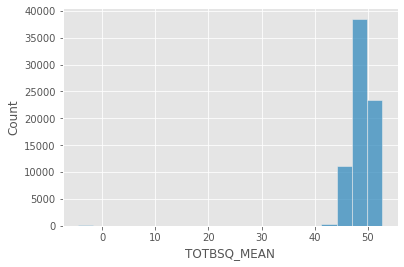

In [616]:
t.plot_histogram(data= extracted_features_copy,col = 'TOTBSQ_MEAN')

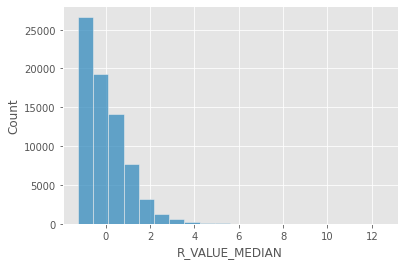

In [618]:
t.plot_histogram(data= extracted_features_copy,col = 'R_VALUE_MEDIAN')

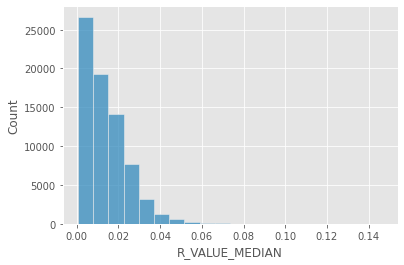

In [619]:
t.plot_histogram(data= extracted_features,col = 'R_VALUE_MEDIAN')

In [585]:
extracted_features['TOTPOT_MAX']

0        0.016948
1        0.092772
2        0.092772
3        0.092772
4        0.092772
           ...   
73487    0.341327
73488    0.341327
73489    0.341327
73490    0.232973
73491    0.083323
Name: TOTPOT_MAX, Length: 73492, dtype: float64

In [588]:
extracted_features_copy['TOTPOT_MAX']

0        0.016948
1        0.092772
2        0.092772
3        0.092772
4        0.092772
           ...   
73487    0.341327
73488    0.341327
73489    0.341327
73490    0.232973
73491    0.083323
Name: TOTPOT_MAX, Length: 73492, dtype: float64

In [630]:
small_range

['TOTBSQ_STDDEV',
 'TOTPOT_MAX',
 'TOTPOT_STDDEV',
 'TOTUSJZ_MIN',
 'TOTUSJZ_MEAN',
 'ABSNJZH_MEAN',
 'ABSNJZH_MEDIAN',
 'ABSNJZH_MAX',
 'USFLUX_MAX',
 'TOTFZ_MEAN',
 'TOTFZ_MEDIAN',
 'TOTFZ_MAX',
 'TOTFZ_STDDEV',
 'MEANPOT_MIN',
 'MEANPOT_MEDIAN',
 'MEANPOT_MAX',
 'EPSZ_MIN',
 'EPSZ_MEAN',
 'EPSZ_MEDIAN',
 'SHRGT45_MEDIAN',
 'SHRGT45_MAX',
 'MEANGAM_MIN',
 'MEANGAM_MEAN',
 'MEANGAM_MEDIAN',
 'MEANGAM_MAX',
 'MEANGAM_STDDEV',
 'MEANGBT_MEAN',
 'MEANGBT_MEDIAN',
 'MEANGBT_STDDEV',
 'MEANGBZ_MIN',
 'MEANGBZ_MEAN',
 'MEANJZH_MEAN',
 'MEANJZH_MEDIAN',
 'MEANJZH_MAX',
 'MEANJZH_STDDEV',
 'TOTFY_MIN',
 'TOTFY_MEAN',
 'TOTFY_MEDIAN',
 'TOTFY_MAX',
 'MEANJZD_MEAN',
 'MEANJZD_MAX',
 'MEANJZD_STDDEV',
 'MEANALP_MIN',
 'EPSY_STDDEV',
 'EPSX_MIN',
 'EPSX_MEAN',
 'R_VALUE_MEDIAN',
 'R_VALUE_MAX',
 'R_VALUE_STDDEV']

In [629]:
large_range

['TOTUSJH_MEAN',
 'TOTUSJH_MEDIAN',
 'TOTUSJH_MAX',
 'TOTBSQ_MIN',
 'TOTBSQ_MEAN',
 'TOTBSQ_MEDIAN',
 'TOTBSQ_MAX',
 'TOTUSJZ_MEDIAN',
 'ABSNJZH_MIN',
 'SAVNCPP_MIN',
 'SAVNCPP_MEAN',
 'SAVNCPP_MEDIAN',
 'SAVNCPP_STDDEV',
 'USFLUX_MIN',
 'USFLUX_MEAN',
 'MEANPOT_MEAN',
 'MEANPOT_STDDEV',
 'EPSZ_STDDEV',
 'MEANSHR_MIN',
 'MEANSHR_MEAN',
 'MEANSHR_MAX',
 'MEANSHR_STDDEV',
 'SHRGT45_MIN',
 'MEANGBT_MIN',
 'MEANGBT_MAX',
 'MEANGBZ_MAX',
 'MEANGBZ_STDDEV',
 'MEANGBH_MIN',
 'MEANGBH_MAX',
 'MEANGBH_STDDEV',
 'TOTFY_STDDEV',
 'MEANJZD_MEDIAN',
 'MEANALP_MAX']

In [507]:
cols = Tranformations(summary_table, extracted_features).get_features_with_small_outliers()
lol = Tranformations(summary_table, extracted_features).z_score_normalisation(cols)
lol

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,-0.735291,-0.523316,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,-0.751406,-1.018028,-0.522462
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,-0.643844,-0.610015,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,-0.760730,-1.068355,-0.565512
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,-0.617187,-0.626310,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,-0.794348,-1.047453,-0.544808
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,-0.632381,-0.617680,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,-0.839204,-1.003047,-0.530952
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,-0.644773,-0.623663,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,-0.902026,-0.959207,-0.502661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.638313e+23,1213.622123,...,-0.219094,-0.898289,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.166709,-0.208560,-0.738647
73488,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.632911e+23,1233.768697,...,-0.402490,-0.905764,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.152597,-0.317209,-0.738647
73489,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.509804e+23,1233.768697,...,-0.389638,-0.908068,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.074629,-0.314661,-0.738647
73490,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.011235,1.833150e+09,3.886825e+20,-2.509804e+23,1210.220238,...,-0.092177,-0.646513,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,-0.030204,-0.336547,-0.738647


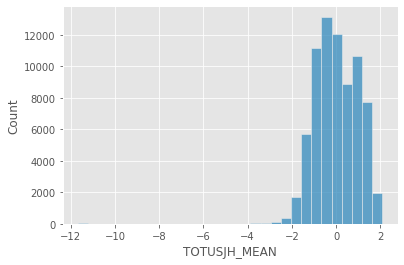

In [548]:
t = Transformations(summary_table, extracted_features)
t.plot_histogram(extracted_features,'TOTUSJH_MEAN',bins=30)

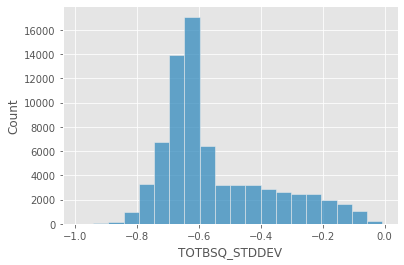

In [499]:
sns.histplot(data=extracted_features, x='TOTBSQ_STDDEV',bins=20);

In [496]:
extracted_features

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,1.692918e+10,2.847211e+23,2.315281e+13,146.325834,3.000497e+12,1.461355e+22,-6.119242e+24,8971.551780,...,3.124452,2.086743,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,0.005793,0.003070,0.090520
1,M,1235.758338,1.686800e+10,2.847211e+23,2.315281e+13,146.325834,2.968113e+12,1.461355e+22,-6.119242e+24,8866.733358,...,3.421047,1.921320,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,0.005694,0.002457,0.072494
2,M,1230.825617,1.661999e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.429395e+22,-5.970181e+24,8866.733358,...,3.507505,1.890229,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,0.005336,0.002712,0.081163
3,M,1230.825617,1.649329e+10,2.830858e+23,2.315281e+13,146.325834,2.968113e+12,1.408501e+22,-5.970181e+24,8866.733358,...,3.458225,1.906696,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,0.004858,0.003252,0.086965
4,M,1213.181555,1.646335e+10,2.820508e+23,2.315281e+13,146.325834,2.968113e+12,1.407693e+22,-5.970181e+24,8866.733358,...,3.418034,1.895281,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,0.004189,0.003786,0.098811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73487,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.638313e+23,1213.622123,...,4.798655,1.371292,0.003083,1.073243e+22,0.406031,0.011463,9.527916e+21,0.015569,0.012921,0.000000
73488,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.632911e+23,1233.768697,...,4.203839,1.357030,0.003328,9.842880e+21,0.426722,0.012386,7.793950e+21,0.015419,0.011599,0.000000
73489,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.037251,1.833150e+09,3.886825e+20,-2.509804e+23,1233.768697,...,4.245523,1.352633,0.003500,7.952267e+21,0.456602,0.013045,6.810941e+21,0.014589,0.011630,0.000000
73490,F,20.204053,1.921287e+08,1.133219e+21,4.550620e+11,0.011235,1.833150e+09,3.886825e+20,-2.509804e+23,1210.220238,...,5.210287,1.851682,0.003458,6.579449e+21,0.446511,0.012882,7.305898e+21,0.013472,0.011363,0.000000


In [460]:
outlier_df.pivot_table(columns = 'Feature',margins=True,fill_value=0,aggfunc=np.mean)

Feature,ABSNJZH_MIN,All,MEANALP_MAX,All,MEANGBH_MAX,All,MEANGBH_MIN,All,MEANGBH_STDDEV,All,...,TOTUSJH_MEAN,All,TOTUSJH_MEDIAN,All,TOTUSJZ_MEDIAN,All,USFLUX_MEAN,All,USFLUX_MIN,All
Log tranform,0.000000,0.000000,0.278886,0.278886,0.071512,0.071512,0.157139,0.157139,0.000000,0.000000,...,1.316602,1.316602,6.354485,6.354485,0.000000,0.000000,0.000000,0.000000,0.020496,0.020496
Square Root Transform,0.000000,0.000000,9.942563,9.942563,1.392532,1.392532,1.465230,1.465230,0.000000,0.000000,...,1.594335,1.594335,1.907412,1.907412,0.000000,0.000000,0.000000,0.000000,1.411203,1.411203
Third_Quartile_clamp,3.294963,3.294963,1.228079,1.228079,1.211998,1.211998,1.206195,1.206195,3.293627,3.293627,...,1.276603,1.276603,1.265508,1.265508,2.923353,2.923353,3.182037,3.182037,1.209502,1.209502


In [326]:
summary_table_copy = summary_table.copy()
data_copy = extracted_features.copy()
clamp_to_third_quartile(data_copy)

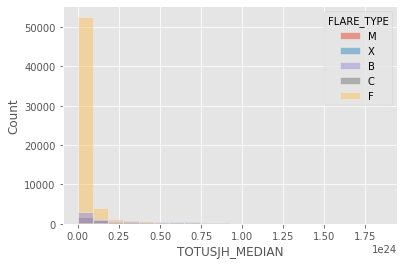

In [467]:
sns.histplot(data = extracted_features, x= 'TOTUSJH_MEDIAN', bins=20,hue = 'FLARE_TYPE');

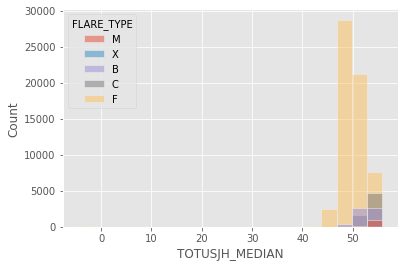

In [464]:
sns.histplot(x= np.log(extracted_features['TOTUSJH_MEDIAN']+0.01), bins=20,hue = extracted_features['FLARE_TYPE']);

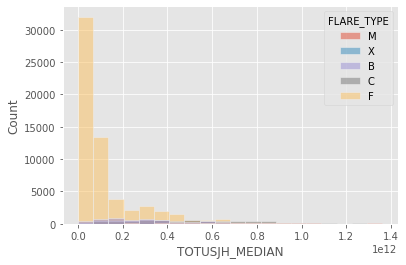

In [465]:
sns.histplot(x= np.sqrt(extracted_features['TOTUSJH_MEDIAN']+0.01), bins=20,hue = extracted_features['FLARE_TYPE']);

<AxesSubplot:xlabel='TOTUSJH_MEDIAN', ylabel='Count'>

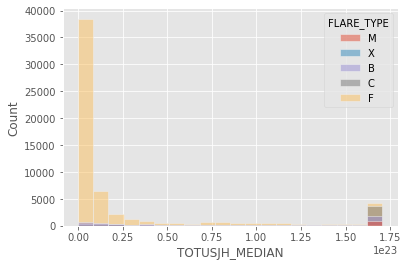

In [468]:
sns.histplot(data = data_copy, x='TOTUSJH_MEDIAN', bins=20,hue='FLARE_TYPE')

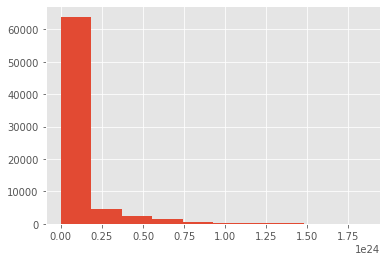

In [441]:
plt.hist(extracted_features['TOTUSJH_MEDIAN']);

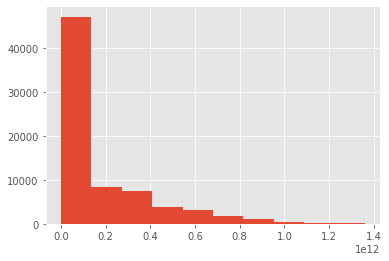

In [442]:
plt.hist(np.sqrt(extracted_features['TOTUSJH_MEDIAN']));

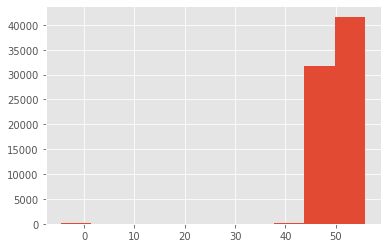

In [443]:
plt.hist(np.log(extracted_features['TOTUSJH_MEDIAN']+0.01));

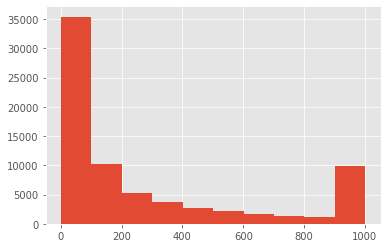

In [391]:

plt.hist(data_copy['TOTUSJH_MIN']);


In [403]:
from scipy import stats
boxcox = stats.skew(stats.boxcox(extracted_features['TOTUSJH_MIN']+0.01)[0])
boxcox

-0.004647359092501542

In [383]:
extracted_features['TOTUSJH_MIN'].min()

0.0

In [373]:
np.sqrt(extracted_features['TOTUSJH_MIN']).skew()

1.5313746647630113

In [374]:
data_copy['TOTUSJH_MIN'].skew()

1.2123210145489758

In [371]:
np.sqrt(extracted_features['TOTUSJH_MIN']).skew()

1.5313746647630113

In [323]:
plt.hist(summary_table_copy['MEANGBZ_STDDEV'],bins=5)

KeyError: 'MEANGBZ_STDDEV'

In [46]:
extracted_features = pd.read_csv(os.path.join(os.getcwd(),"data","extracted_features_cleaned.csv"))
extracted_features.head(5)

,FLARE_TYPE,TOTUSJH_MIN,TOTUSJH_MEAN,TOTUSJH_MEDIAN,TOTUSJH_MAX,TOTUSJH_STDDEV,TOTBSQ_MIN,TOTBSQ_MEAN,TOTBSQ_MEDIAN,TOTBSQ_MAX,...,EPSX_MIN,EPSX_MEAN,EPSX_MEDIAN,EPSX_MAX,EPSX_STDDEV,R_VALUE_MIN,R_VALUE_MEAN,R_VALUE_MEDIAN,R_VALUE_MAX,R_VALUE_STDDEV
0,M,1235.758338,23.552304,54.005797,30.773137,146.325834,28.729799,51.036236,NaN,9.101815,...,-0.735291,-0.523316,0.001022,9.569708e+22,0.078014,0.001580,1.042028e+23,-0.751406,-1.018028,-0.522462
1,M,1235.758338,23.548684,54.005797,30.773137,146.325834,28.718947,51.036236,NaN,9.090063,...,-0.643844,-0.610015,0.001101,8.896863e+22,0.069304,0.001531,9.711712e+22,-0.760730,-1.068355,-0.565512
2,M,1230.825617,23.533872,54.000037,30.773137,146.325834,28.718947,51.014124,NaN,9.090063,...,-0.617187,-0.626310,0.001097,7.846757e+22,0.067636,0.001505,1.101299e+23,-0.794348,-1.047453,-0.544808
3,M,1230.825617,23.526219,54.000037,30.773137,146.325834,28.718947,50.999398,NaN,9.090063,...,-0.632381,-0.617680,0.000980,6.731929e+22,0.065579,0.001448,1.264426e+23,-0.839204,-1.003047,-0.530952
4,M,1213.181555,23.524402,53.996374,30.773137,146.325834,28.718947,50.998824,NaN,9.090063,...,-0.644773,-0.623663,0.000900,5.629746e+22,0.059346,0.001551,1.403329e+23,-0.902026,-0.959207,-0.502661


In [47]:
X = extracted_features.iloc[:,1:].dropna(axis=1)
y = extracted_features.iloc[:,0]
y_encoded = LabelEncoder().fit_transform(y)
# y_encoded
X.shape,y.shape

((73492, 87), (73492,))

In [45]:
X.isna().sum().sort_values(ascending=False)

NameError: name 'drop_nan_cols' is not defined

In [34]:
X.isna().sum().sort_values(ascending=False)

TOTBSQ_MEDIAN     73492
USFLUX_MEAN       73468
MEANGBH_STDDEV    73277
ABSNJZH_MIN       40491
MEANPOT_STDDEV    37020
                  ...  
USFLUX_MEDIAN         0
USFLUX_MIN            0
SAVNCPP_STDDEV        0
SAVNCPP_MAX           0
R_VALUE_STDDEV        0
Length: 96, dtype: int64

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# model = lgb.LGBMClassifier()
# model.fit(X_train, y_train)

In [15]:
predictions = model.predict(X_test)
accuracy = f1_score(y_test, predictions,average='micro')
print("F1 Score: %.2f%%" % (accuracy * 100.0))

F1 Score: 96.38%


In [24]:
np.unique(predictions, return_counts = True)

(array(['B', 'C', 'F', 'M', 'X'], dtype=object),
 array([ 1326,  1904, 18443,   298,    77], dtype=int64))

In [48]:
f1_score_models = {}
auc_score_models = {}
acc_score_models = {}
def plot_roc_cm(model_name,cm,n_classes, fpr, tpr, roc_auc,class_report_df,average = "macro"):

  fig,ax = plt.subplots(1,3,figsize=(25,6))
  if average == "micro":
    
    ax[2].plot(fpr['avg / total'], tpr['avg / total'],
        label='micro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc['avg / total']),
        color='violet', linestyle='-', linewidth=4)

  else:
    
    ax[2].plot(fpr[average], tpr[average],
        label='macro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc['avg / total']),
        color='violet', linestyle='-', linewidth=4)

  # plt.plot(fpr["macro"], tpr["macro"],
  #         label='macro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["macro"]),
  #         color='orange', linestyle=':', linewidth=4)
  lw = 2
  colors = cycle(['red', 'green', 'blue','purple','orange'])
  mapping= {
      0: 'H',
      1:'S1',
      2: 'S2',
      3: 'S3',
      4: 'S4'
  }
  for i, color in zip(range(n_classes), colors):
      ax[2].plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(mapping[i], roc_auc[i]))
  labels = ['H','S1','S2','S3','S4','avg/total']
  sns.heatmap(cm,ax=ax[0],annot=True)
  ax[0].set_title(f"Confusion Matrix for {model_name}")
  ax[0].set_xticklabels(labels[:-1], rotation=45, ha='left',weight='bold',fontsize = 14)
  ax[0].set_yticklabels(labels[:-1], rotation=45, ha='right',weight='bold',fontsize = 14)
  sns.heatmap(class_report_df.iloc[:,:].drop(['support','pred'],axis=1),annot=True,ax=ax[1])
  ax[1].set_title(f'Classificaton report for {model_name}')

  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='left',weight='bold',fontsize = 12)
  ax[1].set_yticklabels(labels, rotation=45, ha='right',weight='bold',fontsize = 14)
  # ax[1].set_xticklabels(rotation=45)
  # ax[1].set_yticklabels(rotation=45, weight = 'bold')
  ax[2].plot([0, 1], [0, 1], 'k--', lw=lw)
  ax[2].axis(xmin=0.0,xmax=1,ymin=0,ymax=1.05)
  
  ax[2].set_xlabel('False Positive Rate',weight='bold',fontsize = 14)
  ax[2].set_ylabel('True Positive Rate',weight='bold',fontsize = 14)
  ax[2].set_title(f'ROC Curve for {model_name}')
  ax[2].legend(loc="lower right")
  ax[2].set_xticklabels(ax[2].get_xticklabels(),weight='bold',fontsize = 10)
  ax[2].set_yticklabels(ax[2].get_yticklabels(),weight='bold',fontsize = 10)


def class_report(model_name,y_true, y_pred, y_score=None, average='macro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    cm = confusion_matrix(y_true, y_pred)
    
    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            
            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        ac_score = (cm.diagonal()/cm.sum(axis=1)).tolist()
        
        class_report_df['Accuracy'] = pd.Series(ac_score)
        class_report_df.loc['avg / total','Accuracy'] = accuracy_score(y_true,y_pred)
        # np.append(ac_score,accuracy_score(y_true,y_pred))
        # class_report_df['Accuracy']  = pd.Series(ac_score)
        # class_report_df['AUC'] = pd.Series(roc_auc)
        
    
    # for score in ac_score:
    #   print(score)

    # print(accuracy_score(y_true,y_pred))
    plot_roc_cm(model_name,cm,n_classes,fpr,tpr,roc_auc,class_report_df,average)
    return class_report_df

def kfold(model,n_splits,X,y):
  kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)
  cv_score_auc =[]
  cv_score_f1 = []
  i=1
  for train_index,test_index in kf.split(X,y):
      
      xtr,xvl = X[train_index],X[test_index]
      ytr,yvl = y[train_index],y[test_index]
      
      #model
      model.fit(xtr,ytr)
      score_auc = roc_auc_score(yvl,model.predict_proba(xvl),multi_class='ovr',average='macro')
      score_f1 = f1_score(yvl,model.predict(xvl),average='macro')
      # print('ROC AUC score:',score_auc)
      # print('F1 score: ', score_f1)
      cv_score_auc.append(score_auc)
      cv_score_f1.append(score_f1)
      # pred_test = lr.predict_proba(X_test)[:,1]
      # pred_test_full +=pred_test
      i+=1

  return cv_score_f1, cv_score_auc

def grid_search(estimator, params, X_train,y_train,cv=10):
  grid = GridSearchCV(estimator=estimator, param_grid=params, cv=cv, refit = True)
  grid.fit(X_train, y_train)
  print(f'Best params : {grid.best_params_}')
  print(f'Best score: {grid.best_score_}')

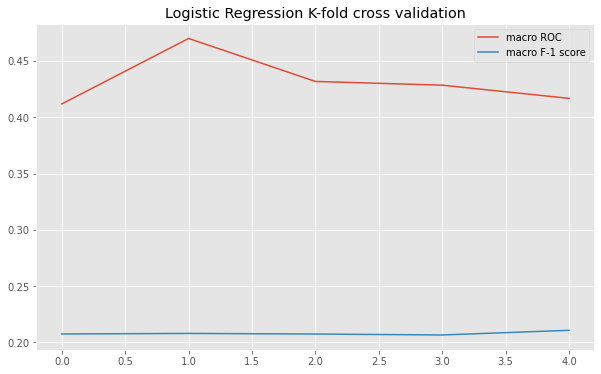

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,roc_curve,auc,f1_score,accuracy_score,\
classification_report,multilabel_confusion_matrix, roc_auc_score,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder,LabelBinarizer
lr = LogisticRegression(multi_class = 'ovr', penalty = 'l2')
f1_array_log,auc_array_log = kfold(lr, 5, X.values, y_encoded)
f1_score_models['Logistic Regression'] = np.mean(f1_array_log)
auc_score_models['Logistic Regression'] = np.mean(auc_array_log)
plt.figure(figsize = (10,6))
plt.plot(auc_array_log,label = 'macro ROC');
plt.plot(f1_array_log, label = 'macro F-1 score');
plt.title("Logistic Regression K-fold cross validation")
plt.legend();

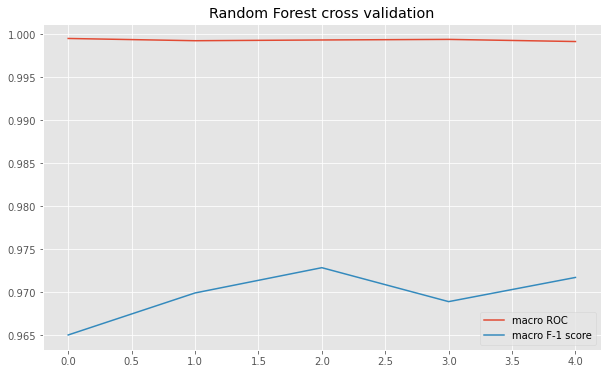

In [67]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
model3 = 'Random Forest'
model3 = RandomForestClassifier(n_estimators=50,criterion='entropy',max_features='log2')
f1_array_rf,auc_array_rf = kfold(model3, 5, X.values, y_encoded)
f1_score_models['Random Forest'] = np.mean(f1_array_rf)
auc_score_models['Random Forest'] = np.mean(auc_array_rf)
plt.figure(figsize = (10,6))
plt.plot(auc_array_rf,label = 'macro ROC');
plt.plot(f1_array_rf, label = 'macro F-1 score');
plt.title("Random Forest cross validation")
plt.legend();

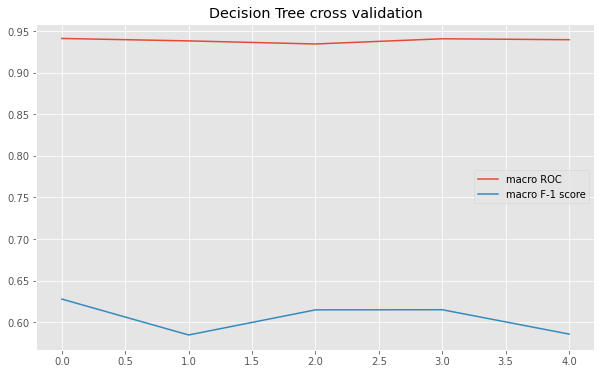

In [69]:
from sklearn.tree import DecisionTreeClassifier
model4 = 'Decision Tree'
model4 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, max_leaf_nodes=100)
f1_array_dt,auc_array_dt = kfold(model4, 5, X.values, y_encoded)
f1_score_models['DT'] = np.mean(f1_array_dt)
auc_score_models['DT'] = np.mean(auc_array_dt)
plt.figure(figsize = (10,6))
plt.plot(auc_array_dt,label = 'macro ROC');
plt.plot(f1_array_dt, label = 'macro F-1 score');
plt.title("Decision Tree cross validation")
plt.legend();

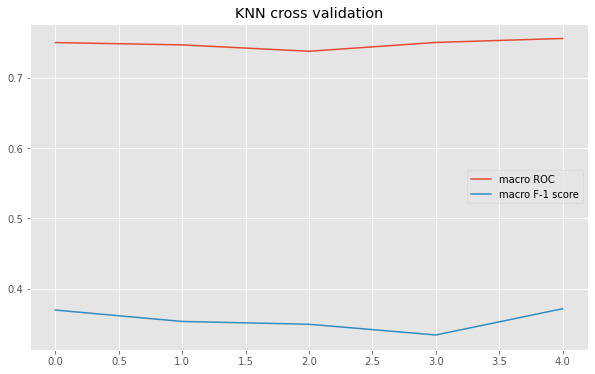

In [72]:
from sklearn.tree import DecisionTreeClassifier
model5 = 'KNN'
model5 = KNeighborsClassifier(weights='uniform')
f1_array_knn,auc_array_knn = kfold(model5, 5,  X.values, y_encoded)
f1_score_models['KNN'] = np.mean(f1_array_knn)
auc_score_models['KNN'] = np.mean(auc_array_knn)
plt.figure(figsize = (10,6))
plt.plot(auc_array_knn,label = 'macro ROC');
plt.plot(f1_array_knn, label = 'macro F-1 score');
plt.title("KNN cross validation")
plt.legend();

In [76]:
f1_score_models

{'Logistic Regression': 0.20809941533963014,
 'Random Forest': 0.9696844509964387,
 'DT': 0.6055399387476523,
 'KNN': 0.3554410455876109}

In [77]:
auc_score_models

{'Logistic Regression': 0.4317046468982625,
 'Random Forest': 0.9993061123589516,
 'DT': 0.9388656674676493,
 'KNN': 0.7480671135161054}

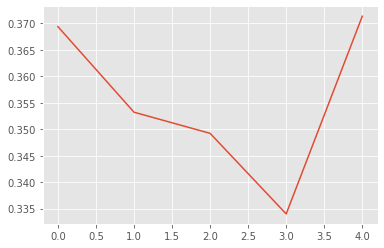

In [86]:
plt.plot(np.array(f1_array_log));

In [104]:
f1_table = pd.DataFrame(columns = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5'])
# f1_table['Model'] = pd.Series(['Logistic Regression','Random Forest','Decision Tree','KNN'])

f1_table = f1_table.append(np.vstack((f1_array_log,f1_array_rf,f1_array_dt,f1_array_knn)))

    

In [108]:
f1_table = pd.DataFrame(columns =  ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5'], data = np.vstack((f1_array_log,f1_array_rf,f1_array_dt,f1_array_knn)))
f1_table.insert(0,'Model',['Logistic Regression','Random Forest','Decision Tree','KNN'])

In [110]:
auc_table = pd.DataFrame(columns =  ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5'], data = np.vstack((auc_array_log,auc_array_rf,auc_array_dt,auc_array_knn)))
auc_table.insert(0,'Model',['Logistic Regression','Random Forest','Decision Tree','KNN'])

In [111]:
auc_table

,Model,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,Logistic Regression,0.411761,0.469895,0.431733,0.428421,0.416713
1,Random Forest,0.999486,0.999225,0.999311,0.999378,0.999131
2,Decision Tree,0.941149,0.938234,0.934518,0.940783,0.939644
3,KNN,0.749985,0.746709,0.737603,0.750204,0.755835


In [112]:
f1_score_models,auc_score_models

({'Logistic Regression': 0.20809941533963014,
  'Random Forest': 0.9696844509964387,
  'DT': 0.6055399387476523,
  'KNN': 0.3554410455876109},
 {'Logistic Regression': 0.4317046468982625,
  'Random Forest': 0.9993061123589516,
  'DT': 0.9388656674676493,
  'KNN': 0.7480671135161054})

In [121]:
scores = pd.DataFrame(columns = ['Model', 'F1 Score', 'AUC Score'])
scores['Model'] = ['Logistic Regression','Random Forest','Decision Tree','KNN']
scores['F1 Score'] = np.array(list(f1_score_models.values()))
scores['AUC Score'] = np.array(list(auc_score_models.values()))
scores

,Model,F1 Score,AUC Score
0,Logistic Regression,0.208099,0.431705
1,Random Forest,0.969684,0.999306
2,Decision Tree,0.605540,0.938866
3,KNN,0.355441,0.748067


In [117]:
save_table()

array([0.20809942, 0.96968445, 0.60553994, 0.35544105])

In [119]:
scores

,Model,F1 Score,AUC Score
0,NaN,0.208099,NaN
1,NaN,0.969684,NaN
2,NaN,0.605540,NaN
3,NaN,0.355441,NaN


In [124]:
save_path_1 = os.path.join(os.getcwd(),"data","scores.csv")
save_path_2 = os.path.join(os.getcwd(),"data","auc_table.csv")
save_path_3 = os.path.join(os.getcwd(),"data","f1_table.csv")

save_table(save_path_1, scores)
save_table(save_path_2, auc_table)
save_table(save_path_3, f1_table)



In [90]:
import pandas as pd
import numpy as np
from data_cleaning.helper_functions import Sample
import os
from tslearn.metrics import dtw, dtw_path
# from dtaidistance import dtw
os.chdir("D:\PyCharm\mvts_fss_ay")

In [4]:
os.getcwd()

'D:\\PyCharm\\mvts_fss_ay'

In [88]:
sample_1 = Sample("FL","M1.0@265_Primary_ar115_s2010-08-06T06_36_00_e2010-08-06T18_24_00.csv")
data_1= sample_1.get_data().iloc[:,:25].set_index('Timestamp')


sample_2 = Sample("FL","M1.0@265_Primary_ar115_s2010-08-06T12_36_00_e2010-08-07T00_24_00.csv")
data_2 = sample_2.get_data().iloc[:,:25].set_index('Timestamp')


In [68]:
timeseries = [data_1.values, data_2.values]
len(timeseries)

2

In [69]:
ds = dtw.distance_matrix_fast(timeseries)

In [70]:
ds

array([[0.00000000e+00, 1.74224799e+24],
       [1.74224799e+24, 0.00000000e+00]])

In [82]:
from dtaidistance import dtw_ndim
d = dtw_ndim.distance(data_1.values, data_2.values)

In [99]:
from tslearn.metrics import dtw_path_limited_warping_length

In [104]:
path,cost = dtw_path_limited_warping_length(data_1.values,data_2.values,max_length = 60)

In [106]:
path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 24),
 (25, 25),
 (26, 26),
 (27, 27),
 (28, 28),
 (29, 29),
 (30, 30),
 (31, 31),
 (32, 32),
 (33, 33),
 (34, 34),
 (35, 35),
 (36, 36),
 (37, 37),
 (38, 38),
 (39, 39),
 (40, 40),
 (41, 41),
 (42, 42),
 (43, 43),
 (44, 44),
 (45, 45),
 (46, 46),
 (47, 47),
 (48, 48),
 (49, 49),
 (50, 50),
 (51, 51),
 (52, 52),
 (53, 53),
 (54, 54),
 (55, 55),
 (56, 56),
 (57, 57),
 (58, 58),
 (59, 59)]

In [83]:
d

5.288041684618831e+24

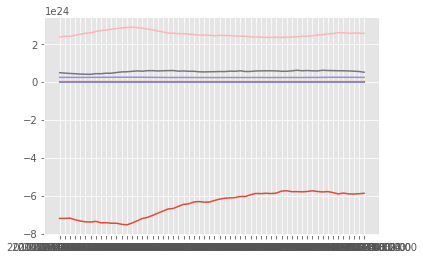

In [78]:
import matplotlib.pyplot as plt
plt.plot(data_1);

In [91]:
print("Doing something.......")
dtw_score = dtw(data_1.values, data_2.values)
optimal_path, dtw_score = dtw_path(data_1.values, data_2.values)
print(dtw_score)

Doing something.......
5.288041684618831e+24


In [92]:
optimal_path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 0),
 (22, 0),
 (23, 0),
 (24, 0),
 (25, 0),
 (26, 0),
 (27, 0),
 (28, 0),
 (29, 0),
 (30, 0),
 (31, 1),
 (32, 2),
 (33, 3),
 (34, 4),
 (35, 5),
 (36, 6),
 (37, 7),
 (38, 8),
 (38, 9),
 (38, 10),
 (38, 11),
 (38, 12),
 (38, 13),
 (38, 14),
 (38, 15),
 (38, 16),
 (38, 17),
 (38, 18),
 (38, 19),
 (38, 20),
 (38, 21),
 (38, 22),
 (38, 23),
 (38, 24),
 (38, 25),
 (38, 26),
 (38, 27),
 (38, 28),
 (39, 29),
 (40, 30),
 (41, 31),
 (42, 32),
 (43, 33),
 (44, 34),
 (44, 35),
 (44, 36),
 (44, 37),
 (44, 38),
 (44, 39),
 (44, 40),
 (44, 41),
 (44, 42),
 (44, 43),
 (44, 44),
 (44, 45),
 (44, 46),
 (44, 47),
 (44, 48),
 (44, 49),
 (44, 50),
 (44, 51),
 (45, 52),
 (46, 52),
 (47, 52),
 (48, 52),
 (49, 52),
 (50, 53),
 (51, 53),
 (52, 54),
 (53, 55),
 (54, 55),
 (55, 55),
 (56, 56),
 (57, 57),
 (58,

In [94]:
from scipy.spatial.distance import cdist
mat = cdist(data_1,data_2)

In [11]:
timeseries

[array([[ 9.80993502e+02,  1.55126990e+10,  2.24018865e+23, ...,
         -2.29598955e-02, -1.14206616e-01,  4.23938496e+00],
        [ 9.87271725e+02,  1.55504761e+10,  2.25286676e+23, ...,
         -2.16855031e-02, -1.15859739e-01,  4.23839594e+00],
        [ 9.85015683e+02,  1.55010861e+10,  2.23891434e+23, ...,
         -2.09874702e-02, -1.16127588e-01,  4.32337783e+00],
        ...,
        [ 9.60922129e+02,  1.45279914e+10,  2.27234756e+23, ...,
         -2.85492729e-02, -1.32592503e-01,  4.18940610e+00],
        [ 9.48057292e+02,  1.44775380e+10,  2.26017934e+23, ...,
         -2.78014664e-02, -1.33112838e-01,  4.20024439e+00],
        [ 9.42901959e+02,  1.44408706e+10,  2.25813277e+23, ...,
         -2.59455335e-02, -1.32386334e-01,  4.15426416e+00]]),
 array([[ 9.45603836e+02,  1.44168928e+10,  2.16030904e+23, ...,
         -2.74050048e-02, -1.26305318e-01,  4.19970059e+00],
        [ 9.48013281e+02,  1.44111263e+10,  2.17321586e+23, ...,
         -2.79056539e-02, -1.27375915e

In [36]:
mat

array([[9.49115267e+23, 1.02079629e+24, 1.06660827e+24, ...,
        1.43466583e+24, 1.43876292e+24, 1.43328464e+24],
       [9.47653480e+23, 1.01881607e+24, 1.06475760e+24, ...,
        1.43301543e+24, 1.43741136e+24, 1.43181990e+24],
       [9.35585580e+23, 1.00684516e+24, 1.05264210e+24, ...,
        1.42042769e+24, 1.42478147e+24, 1.41898149e+24],
       ...,
       [3.67629114e+23, 2.95159861e+23, 2.56084628e+23, ...,
        2.00049616e+23, 2.11687714e+23, 2.16096458e+23],
       [3.81469947e+23, 3.09189069e+23, 2.69285096e+23, ...,
        1.88133186e+23, 2.00030872e+23, 2.03695430e+23],
       [3.96826261e+23, 3.25346241e+23, 2.83121185e+23, ...,
        1.59424677e+23, 1.70902562e+23, 1.71306004e+23]])

In [96]:
import matplotlib.pyplot as plt
import numpy

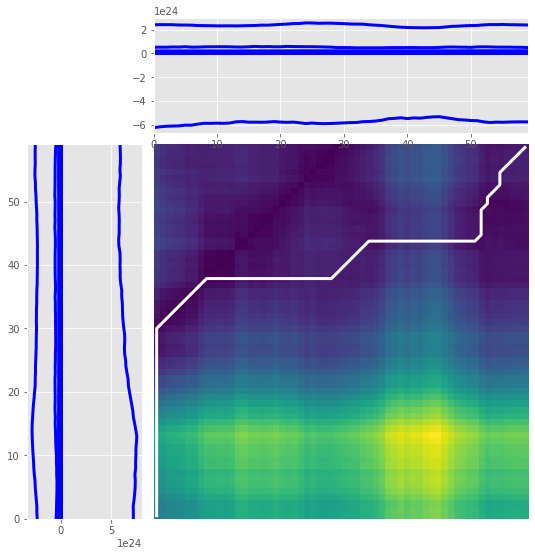

In [98]:
dtw_score = dtw(data_1, data_2)
path, sim = dtw_path(data_1, data_2)

sz = data_1.shape[0]

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)


mat = cdist(data_1,data_2)

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), data_2, "b-", linewidth=3.)
# ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- data_1, numpy.arange(sz), "b-", linewidth=3.)
# ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()